In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

We will use simple economic model of Churn:

You have historical data about customers who churn and not churn.
You have a predictive model which for every customer predict whether he will churn or not churn next month.
You know if you give a discount d% to a churn customer, he will not churn.
Telecom company do not have any accompanying expenses on any discount strategy.
Baseline ("0 profit") solution corresponds to the case where we do not apply any discount strategy and loose all churned clients

(1) 1. What is the percentage of MonthlyCharges payed by customers who will Churn? Single integer number 0..100.


In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4225 non-null   object 
 1   gender            4225 non-null   object 
 2   SeniorCitizen     4225 non-null   int64  
 3   Partner           4225 non-null   object 
 4   Dependents        4225 non-null   object 
 5   tenure            4225 non-null   int64  
 6   PhoneService      4225 non-null   object 
 7   MultipleLines     4225 non-null   object 
 8   InternetService   4225 non-null   object 
 9   OnlineSecurity    4225 non-null   object 
 10  OnlineBackup      4225 non-null   object 
 11  DeviceProtection  4225 non-null   object 
 12  TechSupport       4225 non-null   object 
 13  StreamingTV       4225 non-null   object 
 14  StreamingMovies   4225 non-null   object 
 15  Contract          4225 non-null   object 
 16  PaperlessBilling  4225 non-null   object 


In [4]:
int(df[df['Churn']=='Yes']['MonthlyCharges'].sum()/df['MonthlyCharges'].sum()*100)

30

(1) 2. Compute the profit of 20% discount (MonthlyCharges based) on a test set in scenario where you have "perfect", 100% accurate classification model. How much money company saves, assuming all customers accepts it and do not churn? Single float number, with 2 significant digits, e.g. 10.16 .

In [5]:
df_test = pd.read_csv("test.csv")

In [6]:
np.round(df_test[df_test['Churn']=='Yes']['MonthlyCharges'].sum()*0.8,2)

45331.72

(1) 3. Build any binary classification model, which output probabilities (e.g. Logistic Regression, Gradient Boosting, etc.) using training set. Make predictions on a test set. Upload a csv file with your predictions (it should contain 2 columns, customerID and PredictedYes). For all remaining computations you must use these predictions.

In [7]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:
df[pd.to_numeric(df.TotalCharges, errors='coerce').isnull()]['TotalCharges'].index

Int64Index([690, 766, 1128, 1717, 1904, 1944, 3221], dtype='int64')

In [9]:
arr_none = list(df[pd.to_numeric(df.TotalCharges, errors='coerce').isnull()]['TotalCharges'].index)
for i in arr_none:
    df.loc[i,'TotalCharges'] = str('0')

In [10]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], downcast="float")

In [11]:
def onehot_and_bin(df_):
    categorical_columns = [c for c in df_.columns if df_[c].dtype.name == 'object'][1:]
    for i in categorical_columns:
        if len(df_[i].unique())==2:
            val_col = np.sort(df_[i].unique())
            df_.loc[(df_[i] == val_col[0]), i] = 0 #No
            df_.loc[(df_[i] == val_col[1]), i] = 1 #Yes
            df_[i] = pd.to_numeric(df_[i])
        elif len(df_[i].unique())>2:
            df_ = pd.concat([df_,pd.get_dummies(df_[i],prefix=i)], axis=1).drop(i,axis=1)
    return df_

In [12]:
df = onehot_and_bin(df)

In [86]:
from sklearn.linear_model import LogisticRegression
X_train = df.drop(['customerID','Churn'], axis=1)
y_train = df['Churn']
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [87]:
clf.score(X_train, y_train)

0.8009467455621302

In [88]:
arr_none = list(df_test[pd.to_numeric(df_test.TotalCharges, errors='coerce').isnull()]['TotalCharges'].index)
for i in arr_none:
    df_test.loc[i,'TotalCharges'] = str('0')
df_test["TotalCharges"] = pd.to_numeric(df_test["TotalCharges"], downcast="float")

In [89]:
df_test = onehot_and_bin(df_test)

In [90]:
X_test = df_test.drop(['customerID','Churn'], axis=1)
y_test = df_test['Churn']
clf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [91]:
clf.predict_proba(X_test)

array([[0.94224653, 0.05775347],
       [0.58908226, 0.41091774],
       [0.80666312, 0.19333688],
       ...,
       [0.99338105, 0.00661895],
       [0.70660036, 0.29339964],
       [0.97557715, 0.02442285]])

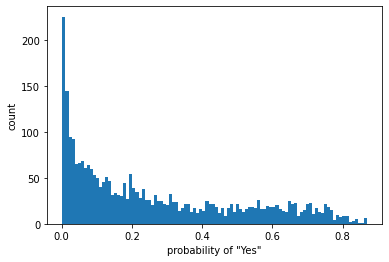

In [92]:
plt.hist(clf.predict_proba(X_test)[:, 1:],bins=100)
plt.xlabel('probability of "Yes"')
plt.ylabel('count')
plt.show()

In [93]:
from sklearn.metrics import accuracy_score

In [94]:
accuracy_score(clf.predict(X_test),y_test)

0.808374733853797

In [95]:
arr_prob = clf.predict_proba(X_test)[:, 1]

In [96]:
d = {'customerID': df_test['customerID'], 'PredictedYes': arr_prob}
df_prob = pd.DataFrame(data=d)
df_prob

,customerID,PredictedYes
0,8659-IOOPU,0.057753
1,0887-HJGAR,0.410918
2,1029-QFBEN,0.193337
3,7579-OOPEC,0.350959
4,8473-VUVJN,0.802467
...,...,...
2813,6476-EPYZR,0.094939
2814,0336-PIKEI,0.008856
2815,5201-CBWYG,0.006619
2816,0678-RLHVP,0.293400


In [97]:
df_prob.to_csv('df_prob.csv',index=False)

(1) 4. What is ROC AUC of your model on a test set? Single integer number 0..100.

In [25]:
from sklearn.metrics import roc_auc_score
int(np.round(roc_auc_score(y_test, arr_prob)*100,0))

85

(1) 5. What are TP, FP, TN, FN for probability threshold 0.5 (4 integer numbers divided by a comma, e.g. 10,20,15,5). You can use example from <> spreadsheet to compute the confusion matrix.

In [40]:
TP = 0
FP = 0 
TN = 0
FN = 0
threshold = 0.5
for i in range(len(y_test)):
    if (y_test[i] == 1) and (arr_prob[i] >= threshold):
        TP+=1
    elif (y_test[i] == 0) and (arr_prob[i] >= threshold):
        FP+=1
    elif (y_test[i] == 0) and (arr_prob[i] < threshold):
        TN+=1
    elif (y_test[i] == 1) and (arr_prob[i] < threshold):
        FN+=1

In [41]:
print('TP: ', TP, 'FN: ', FN)
print('FP: ', FP, 'TN: ', TN)

TP:  410 FN:  349
FP:  191 TN:  1868


Compute the effectiveness of discount strategies for different scenarios

(1) 6. Compute the profit of 20% discount (MonthlyCharges based), assuming you give it to all customers predicted as Churned (TP and FP). Single float number, with 2 significant digits, e.g. 10.16 .

In [42]:
np.round((df_test['MonthlyCharges'][(y_test == 0) & (arr_prob <  0.5)].sum() + 
          df_test['MonthlyCharges'][(y_test == 1) & (arr_prob >= 0.5)].sum() * 0.8 + 
          df_test['MonthlyCharges'][(y_test == 0) & (arr_prob >= 0.5)].sum() * 0.8), 2)

149723.29

(1) 7. What if we only give discount (20%) to top p% of customers (p% of customers with the highest probability to churn, predicted by our model). Find p, which maximizes the profit. Recall that p might not coincide with probability threshold outputed by your classifier (e.g. using threshold of 0.65 you end up with 50% of the customers). Single integer number 0..100.

In [99]:
arr_p_and_profit = []
arr_p = []
for p in np.linspace(0,len(arr_prob)-1,100, dtype=int)[::-1]:

    t = np.sort(arr_prob)[p]

    arr_p_and_profit.append(np.round((df_test['MonthlyCharges'][(y_test == 0) & (arr_prob <  t)].sum() + 
                                      df_test['MonthlyCharges'][(y_test == 1) & (arr_prob >= t)].sum() * 0.8 + 
                                      df_test['MonthlyCharges'][(y_test == 0) & (arr_prob >= t)].sum() * 0.8), 2))
    arr_p.append(t)

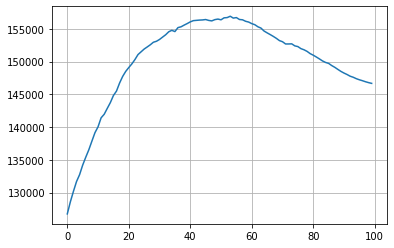

In [106]:
plt.plot(arr_p_and_profit)
plt.grid()

In [107]:
print('optim % =',int(100*np.mean(arr_prob >= arr_p[np.argmax(arr_p_and_profit)])), ' with max profit',np.max(arr_p_and_profit))

optim % = 53  with max profit 156911.78


(1) 8. Instead of 20% discount we now give constant 10$ discount. How your answer to the previous question changes? Single integer number 0..100.

In [117]:
arr_p_and_profit = []
arr_p = []
for p in np.linspace(0,len(arr_prob)-1,100, dtype=int)[::-1]:

    t = np.sort(arr_prob)[p]

    arr_p_and_profit.append(np.round(df_test['MonthlyCharges'][(y_test == 0) & (arr_prob <  t)].sum() + 
                                      np.sum(df_test['MonthlyCharges'][(y_test == 1) & (arr_prob >= t)] - 10) + 
                                      np.sum(df_test['MonthlyCharges'][(y_test == 0) & (arr_prob >= t)] - 10), 2))
    arr_p.append(t)

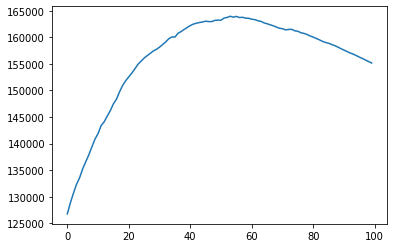

In [119]:
plt.plot(arr_p_and_profit)

In [120]:
print('optim % =',int(100*np.mean(arr_prob >= arr_p[np.argmax(arr_p_and_profit)])), ' with max profit',np.max(arr_p_and_profit))

optim % = 53  with max profit 163956.8


(2) 9. Propose a more viable economic model of Churn (e.g. how additional spendings on advertisement., new customers' aquisition, regular discount companies affect your ML pipeline; how to improve our simple economic model to make it more realistic?). 3000 english symbols. Any submission over 3000 symbols will result in 0 points. Your improvements must incorporate the scenario of usage Churn/Uplift ML models.